In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
from models.ngcf import NGCFModel
import tensorflow as tf
import os
import json
import datetime
from utils.datahandler import DataHandler

In [8]:
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print("GPU being used:")
    print(details.get("device_name", "Unknown GPU"))

GPU being used:
NVIDIA GeForce RTX 3060 Laptop GPU


In [9]:
data_path = os.path.join("..", "datasets", "preprocessed", "movielens")
datahandler_train = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_train.csv"), batch_size=8192
)
datahandler_test = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_test.csv"), batch_size=8192
)
train_ds, test_ds = datahandler_train.load_data(), datahandler_test.load_data()
with open(os.path.join(data_path, "movielens_100k_metadata.json"), "r") as file:
    metadata = json.load(file)

In [10]:
train_ds_repeat = train_ds.repeat()
test_ds_cache = test_ds.cache()

In [14]:
model = NGCFModel(
    num_users=metadata["num_users"],
    num_items=metadata["num_items"],
    num_layers=2,
    embedding_size=128,
    n_fold=1,
    adj_save_dir=os.path.join(data_path, "movielens_100k_adj_mat"),
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)


log_dir = os.path.join(
    "..", "logs", "model_ngcf", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, verbose=1
)


history = model.fit(
    train_ds_repeat,
    epochs=10,
    steps_per_epoch=datahandler_train.steps_per_epoch,
    validation_data=test_ds_cache,
    validation_steps=datahandler_test.steps_per_epoch,
    callbacks=[tensorboard_callback, early_stopping],
    verbose=1,
)

Epoch 1/10
11/11 [==============================] - 6s 163ms/step - loss: 9.4444 - root_mean_squared_error: 3.0732 - val_loss: 4.1881 - val_root_mean_squared_error: 2.0465
Epoch 2/10
11/11 [==============================] - 2s 82ms/step - loss: 3.5735 - root_mean_squared_error: 1.8904 - val_loss: 3.2335 - val_root_mean_squared_error: 1.7982
Epoch 3/10
11/11 [==============================] - 1s 75ms/step - loss: 2.5296 - root_mean_squared_error: 1.5905 - val_loss: 2.3129 - val_root_mean_squared_error: 1.5208
Epoch 4/10
11/11 [==============================] - 1s 72ms/step - loss: 2.1186 - root_mean_squared_error: 1.4555 - val_loss: 2.1977 - val_root_mean_squared_error: 1.4825
Epoch 5/10
11/11 [==============================] - 1s 68ms/step - loss: 1.9125 - root_mean_squared_error: 1.3829 - val_loss: 1.9575 - val_root_mean_squared_error: 1.3991
Epoch 6/10
11/11 [==============================] - 2s 85ms/step - loss: 1.7554 - root_mean_squared_error: 1.3249 - val_loss: 1.8437 - val_root_

In [10]:
model.summary()

Model: "ngcf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embeddings (Embedding)  multiple                 120704    
                                                                 
 item_embeddings (Embedding)  multiple                 212992    
                                                                 
 ngcf_layer (NGCFLayer)      multiple                  32768     
                                                                 
 ngcf_layer_1 (NGCFLayer)    multiple                  32768     
                                                                 
Total params: 399,232
Trainable params: 399,232
Non-trainable params: 0
_________________________________________________________________


In [11]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation metrics, displayed side by side.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["root_mean_squared_error"]
    val_accuracy = history.history["val_root_mean_squared_error"]

    epochs = range(len(history.history["loss"]))  # how many epochs did we run for?

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot loss on the first subplot
    ax1.plot(epochs, loss, label="training_loss")
    ax1.plot(epochs, val_loss, label="val_loss")
    # ax1.set_yscale('log')
    ax1.set_title("Loss")
    ax1.set_xlabel("epochs")
    ax1.legend()

    # Plot accuracy on the second subplot
    ax2.plot(epochs, accuracy, label="training_rmse")
    ax2.plot(epochs, val_accuracy, label="val_rmse")
    # ax2.set_yscale('log')
    ax2.set_title("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()

    plt.tight_layout()  # Adjust the layout
    plt.show()

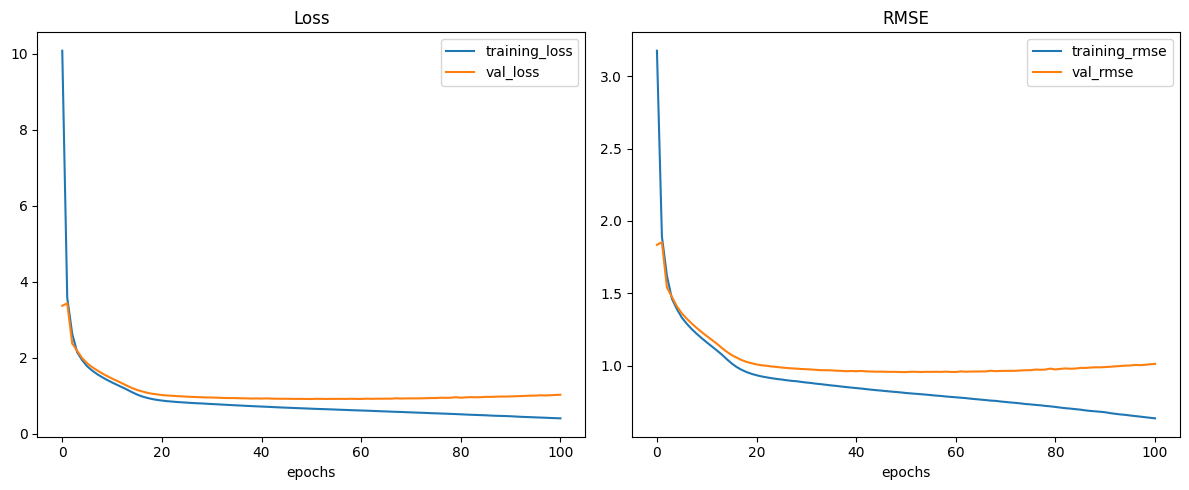

In [12]:
plot_loss_curves(history)

In [16]:
min(history.history["val_loss"])

0.9159125685691833

In [14]:
input = {
    "user_index": tf.constant([0, 4, 9, 3]),
    "item_index": tf.constant([3, 5, 9, 10]),
}
model(input)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([4.7258883, 2.6220837, 4.016217 , 2.6648955], dtype=float32)>